In [4]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2


from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbStabilizerCode import FiveQbStabilizerCodeCircuit
from functions import *


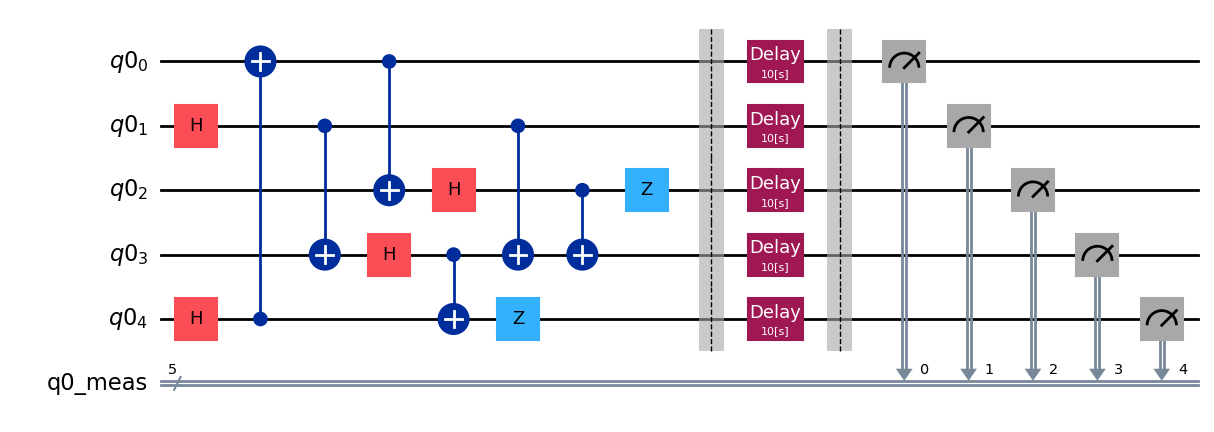

In [5]:


def load_circuit():
    qc = FiveQbStabilizerCodeCircuit(1)

    qc.encode(type='0')

    qc.delay(10, unit='s')

    qc.measure_all()

    return qc

qc = load_circuit()
qc.draw('mpl')



In [6]:
# IonQ access
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [7]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

In [12]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
# print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')



Circuit Depth: 9


In [9]:
circuits = [isa_circuit]

In [10]:
simulation_result = sampler_simulation(qc.physical_circuit, 3200)

for lq in qc.qubits:
    # state = lq.qb_measure
    state = lq.qb_measures
    # state = lq.all_measures
    print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")


  q0_meas: {'00011': 190, '01001': 217, '01100': 191, '01010': 233, '00101': 185, '10111': 185, '10010': 217, '00000': 195, '10100': 203, '00110': 216, '11101': 203, '01111': 189, '11000': 213, '10001': 169, '11110': 191, '11011': 203}


Run experiment

In [ ]:
shots = 3200
# job = backend.run(circuits, shots=shots)

# job_id = job.id()

# print(f"Job ID: {job_id}")


Job ID: 51932f6e-f896-11ef-9c66-3800255d459d


In [35]:
results = extract_results_json_IONQ('5qb_stabilizer_T1_delay10s.json', type='percentage', reverse_order=True)[0]
print(results)

{'00000': 5.720537668021257, '00001': 0.4688965301656768, '00010': 0.3751172241325414, '00011': 5.908096280087528, '00100': 0.31259768677711786, '00101': 5.5329790559549865, '00110': 6.439512347608628, '00111': 0.4688965301656768, '01000': 0.40637699281025325, '01001': 5.970615817442951, '01010': 6.158174429509222, '01011': 0.25007814942169426, '01100': 6.189434198186934, '01101': 0.34385745545482965, '01110': 0.28133791809940606, '01111': 5.595498593310409, '10000': 0.5001562988433885, '10001': 6.033135354798374, '10010': 5.845576742732104, '10011': 0.25007814942169426, '10100': 6.0643951234760864, '10101': 0.2188183807439825, '10110': 0.28133791809940606, '10111': 5.189121600500156, '11000': 6.595811190997186, '11001': 0.40637699281025325, '11010': 0.28133791809940606, '11011': 6.251953735542356, '11100': 0.31259768677711786, '11101': 5.345420443888715, '11110': 5.814316974054392, '11111': 0.1875586120662707}


In [36]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]

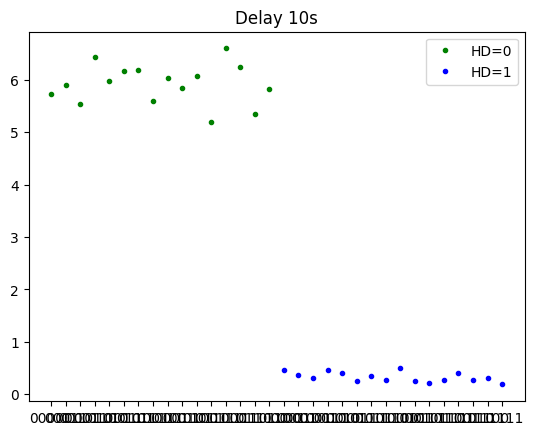

In [38]:
plot_results_hamming_distance(results, 5, valid_states, title='Delay 10s')

In [41]:
print("snr:", calculate_snr(results, valid_states))

snr: 17.70760233918129


TVD

In [42]:
tvd = calculate_tvd(results, generate_uniform_distribution(5, valid_states), percentage=True)

print("Total Variation Distance")
print(f"delay 10s:\t{round(tvd*100,2)}%")

Total Variation Distance
delay 10s:	5.88%
